[Bayesian Modeling in Python](http://nbviewer.jupyter.org/github/markdregan/Bayesian-Modelling-in-Python/blob/master/Section%200.%20Introduction.ipynb).
Section 1 on [Estimatining the Paramteres](http://nbviewer.jupyter.org/github/markdregan/Bayesian-Modelling-in-Python/blob/master/Section%201.%20Estimating%20model%20parameters.ipynb)

Die Biliothek `mathplotlib` wird mindestens in Version `1.4` benötigt. Update bei Bedarf von der Shell mit `conda update matplotlib`. Bibliothek `pymc3` (und seine Abhängigkeit `Theano`) bei Bedarf wie folgt von der Shell installieren:
```
pip install --process-dependency-links git+https://github.com/pymc-devs/pymc3
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

Laden der Beispieldaten ("Google Hangout Chat Data").

Der volle json-Datensatz ist Teil des git-Repositories. Die im Beispiel verwendete kleine csv-Stichprobe von 266 Nachrichten und 14 Variablen beim ersten Durchlauf mit dem Skript `data-prep.py` erzeugen.

In [2]:
# %loadpy data-prep.py
messages = pd.read_csv('data/hangout_chat_data.csv')

In [11]:
print(messages.shape)
messages.head()

(266, 14)


,conversation_id,event_id,timestamp,sender,message_length,num_participants,message_type,prev_timestamp,prev_sender,time_delay_seconds,time_delay_mins,day_of_week,year_month,is_weekend
0,Ugw5Xrm3ZO5mzAfKB7V4AaABAQ,7-H0Z7-FkyB7-HDBYj4KKh,2014-08-15 12:44:12.840015,Mark Regan,14,3,TEXT,2014-08-15 12:44:00.781653,Kieran,12.0,1.0,4,2014-08,0
1,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1JJEmE5K,2013-12-19 11:49:28.552063,Mark Regan,44,2,TEXT,2013-12-19 11:48:50.916592,Willy,37.0,1.0,3,2013-12,0
2,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1NQV6lMv,2013-12-19 11:50:02.249113,Mark Regan,29,2,TEXT,2013-12-19 11:49:50.401824,Willy,11.0,1.0,3,2013-12,0
3,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1RPd1OTh,2013-12-19 11:50:34.906922,Mark Regan,102,2,TEXT,2013-12-19 11:50:11.427353,Willy,23.0,1.0,3,2013-12,0
4,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1XZ3YFlF,2013-12-19 11:51:25.266040,Mark Regan,15,2,TEXT,2013-12-19 11:51:14.914502,Willy,10.0,1.0,3,2013-12,0


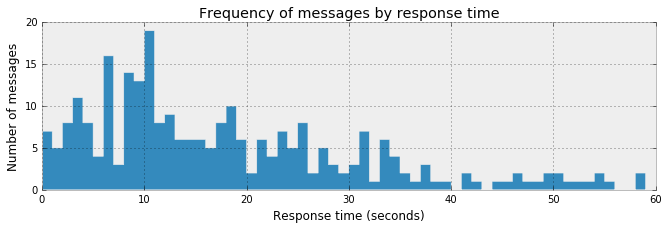

In [5]:
# Plot reponse time

fig = plt.figure(figsize=(11,3))
_ = plt.title('Frequency of messages by response time')
_ = plt.xlabel('Response time (seconds)')
_ = plt.ylabel('Number of messages')
_ = plt.hist(messages['time_delay_seconds'].values, 
             range=[0, 60], bins=60, histtype='stepfilled')

In [6]:
# Fit poisson distribution (because count data) the frequentist way
             
y_obs = messages['time_delay_seconds'].values

def poisson_logprob(mu, sign=-1):
    # poisson_logprob() returns likelihood of the observed data 
    return np.sum(sign*stats.poisson.logpmf(y_obs, mu=mu))

freq_results = opt.minimize_scalar(poisson_logprob)
%time print("The estimated value of mu is: %s" % freq_results['x'])


The estimated value of mu is: 17.5338345754
CPU times: user 48 µs, sys: 12 µs, total: 60 µs
Wall time: 62.9 µs


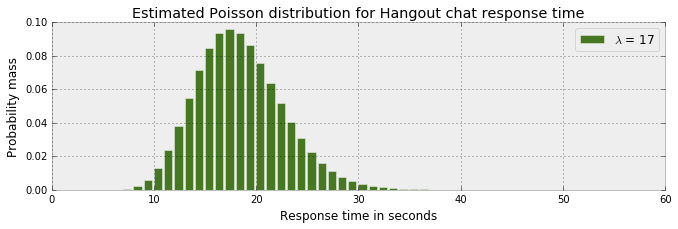

In [7]:
# Plot estimated distribtuion
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
x_lim = 60
mu = np.int(freq_results['x'])
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu, i), color=colors[3])
    
_ = ax.set_xlim(0, x_lim)
_ = ax.set_ylim(0, 0.1)
_ = ax.set_xlabel('Response time in seconds')
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Estimated Poisson distribution for Hangout chat response time')
_ = plt.legend(['$\lambda$ = %s' % mu])

Ein Großteil der Masse der theoretischen Verteilung liegt in [10,30]. Die beobachteten Daten streuen dagegen stärker zwischen zwischen 0 und 60.

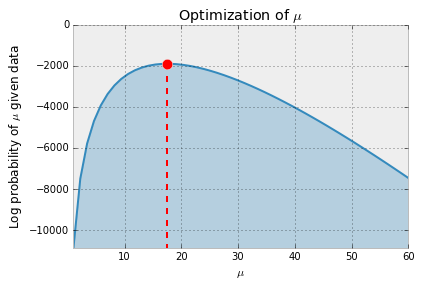

In [8]:
# This is the hill the optimizer is climbing
x = np.linspace(1, 60)
y_min = np.min([poisson_logprob(i, sign=1) for i in x])
y_max = np.max([poisson_logprob(i, sign=1) for i in x])
fig = plt.figure(figsize=(6,4))
_ = plt.plot(x, [poisson_logprob(i, sign=1) for i in x])
_ = plt.fill_between(x, [poisson_logprob(i, sign=1) for i in x], 
                     y_min, color=colors[0], alpha=0.3)
_ = plt.title('Optimization of $\mu$')
_ = plt.xlabel('$\mu$')
_ = plt.ylabel('Log probability of $\mu$ given data')
_ = plt.vlines(freq_results['x'], y_max, y_min, colors='red', linestyles='dashed')
_ = plt.scatter(freq_results['x'], y_max, s=110, c='red', zorder=3)
_ = plt.ylim(ymin=y_min, ymax=0)
_ = plt.xlim(xmin=1, xmax=60)

In [17]:
# Estimate paramaters with Markov Chain Monte Carlo
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=60)
    likelihood = pm.Poisson('likelihood', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

100%|██████████| 200000/200000 [00:15<00:00, 13246.92it/s]


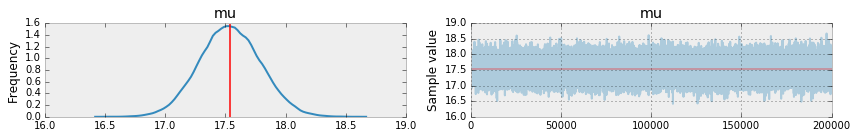

In [18]:
# Plot parameter distribution
_ = pm.traceplot(trace, varnames=['mu'], lines={'mu': freq_results['x']})

Der mit MCMC bestimmte Parameter liegt nah an der frequentistischen Schätzung. 

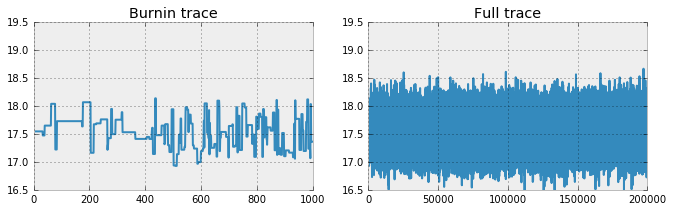

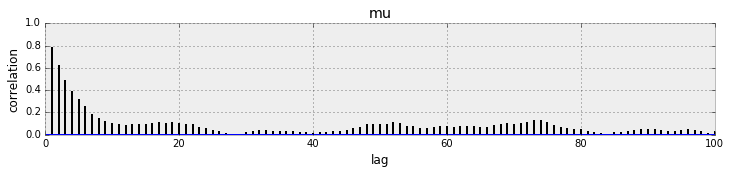

In [19]:
# Test if burning trace not stuck at any particular value
fig = plt.figure(figsize=(11,3))
plt.subplot(121)
_ = plt.title('Burnin trace')
_ = plt.ylim(ymin=16.5, ymax=19.5)
_ = plt.plot(trace.get_values('mu')[:1000])
fig = plt.subplot(122)
_ = plt.title('Full trace')
_ = plt.ylim(ymin=16.5, ymax=19.5)
_ = plt.plot(trace.get_values('mu'))

_ = pm.autocorrplot(trace[:2000], varnames=['mu'])#, ax=ax)